In [1]:
from histgram_3dconv_norefine import MyModel
from video_histgram_dataloader import CustomDataset

/home/wg25r/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse
parser = argparse.ArgumentParser(description="Training script")
parser.add_argument('--fold', type=int, required=True, help='Fold number for cross-validation')
parser.add_argument('--gpu', type=str, default="0", help='GPU id to use')
parser.add_argument('--refine_mode', type=str, default="residual", help='Refine mode', choices=["residual", "direct"])
parser.add_argument('--noise_level', type=float, default=1, help='Noise level') 
parser.add_argument('--steps', type=int, default=25000, help='Number of steps to train')
parser.add_argument('--learning_rate', type=float, default=1e-5, help='Learning rate') 
parser.add_argument('--weight_decay', type=float, default=1e-2, help='Weight decay')
parser.add_argument('--mask_upsample', type=str, default="interpolate", help='Mask upsample method', choices=["interpolate", "transpose_conv", "shuffle"])
parser.add_argument('--refine_see_bg', action="store_true", help='If refine operator can see background')
parser.add_argument('--backbone', type=str, default="4", help='Backbone size to use', choices=["0", "1", "2", "3", "4", "5"])
parser.add_argument('--refine_steps', type=int, default=5, help='Number of refine steps')
parser.add_argument('--background_type', type=str, default="mog2", choices=["mog2", "sub"], help='Background type, mog2 means MOG2, sub means SuBSENSE')
parser.add_argument('--histogram', action="store_true", help='If use histogram')
parser.add_argument('--clip', type=float, default=1, help='Gradient clip norm')
parser.add_argument('--note', type=str, default="", help='Note for this run (for logging purpose)')
parser.add_argument('--conf_penalty', type=float, default=0, help='Confidence penalty, penalize the model if it is too confident')
parser.add_argument('--image_size', type=int, default=512, help="Image size", choices=[512, 640])
parser.add_argument('--hard_shadow', action="store_true", help='If use hard shadow')
parser.add_argument('--lambda2', type=float, default=30, help='Lambda2 for pretrained weights and new weights')
parser.add_argument('--lr_min', type=float, default=1e-5, help='Minimum learning rate')
parser.add_argument('--print_every', type=int, default=100, help='Print every n steps')
parser.add_argument('--val_size', type=int, default=1024, help='Validation size')
parser.add_argument('--lora', action="store_true", help='If use LoRA')
parser.add_argument('--use_difference', action="store_true", help='If use LoRA')
import shlex
args = parser.parse_args(shlex.split('--fold 2 --steps 10000 --val_size 20480000000000000000000 --learning_rate 5e-5 --weight_decay 4e-3 --background_type mog2 --refine_step 1 --backbone 4 --image_size 512 --gpu 0 --clip 2 --conf_penalty 0.05 --lambda2 1 --hard_shadow --note "all 3 classes, removed +conf_pen"'))


In [3]:
import torch

val_dataset = CustomDataset("/home/wg25r/fastdata/CDNet", "/home/wg25r/fastdata/CDNet", args, "val")
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=30, pin_memory=True, persistent_workers=True, prefetch_factor=2, drop_last=True) 

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
model = MyModel(args)
model = torch.nn.DataParallel(model).cuda()
model.load_state_dict(torch.load("5.pth"))

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized: ['segformer.encoder.test.bias', 'segformer.encoder.test.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_4006055/3445821095.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

<All keys matched successfully>

In [5]:
class BinaryConfusion:
    def __init__(self):
        self.tp = 0
        self.fp = 0
        self.fn = 0
        self.tn = 0

    def update(self, y_true, y_pred):

        self.tp += torch.sum((y_true == 1) & (y_pred == 1))
        self.fn += torch.sum((y_true == 1) & (y_pred == 0))
        self.fp += torch.sum((y_true == 0) & (y_pred == 1))
        self.tn += torch.sum((y_true == 0) & (y_pred == 0))


    def get_f1(self):
        precision = self.tp / (self.tp + self.fp) if (self.tp + self.fp) else 0
        recall = self.tp / (self.tp + self.fn) if (self.tp + self.fn) else 0
        if precision + recall == 0:
            return 0
        return 2 * (precision * recall) / (precision + recall)

In [6]:
torch.save(model.state_dict(), "model_ho.pth")
import tqdm
confusion = BinaryConfusion()
with torch.no_grad():
    model.eval()
    for i, (images, masks, ROI) in enumerate(tqdm.tqdm(val_dataloader)):
        images = images.cuda()
        masks = masks.cuda()
        outputs = model(images).argmax(1) == 1
        assert outputs.shape == masks.shape == ROI.shape
        outputs = outputs[(ROI>0.9)]
        masks = masks[(ROI>0.9)]
        assert outputs.shape == masks.shape
        confusion.update(masks, outputs > 0.5)


100%|██████████| 657/657 [25:06<00:00,  2.29s/it]


In [ ]:
confusion.get_f1() #YES!!!!! taiidonghhletaijingzhangyoujingzhangyoujidong
# main.py --fold 2 --steps 20000 --learning_rate 3e-5 --weight_decay 2e-2 --background_type mog2 --refine_step 1 --backbone 4 --image_size 512 --gpu 1 --clip 2 --conf_penalty 0.05 --lambda2 1 --hard_shadow --save_name 2 --final_weight_decay 4e-2 --final_weight_decay 5e-2 --save_name 5

tensor(0.8798, device='cuda:0')

In [8]:
iou = confusion.tp / (confusion.tp + confusion.fp + confusion.fn)

In [ ]:
iou

tensor(0.7854, device='cuda:0')

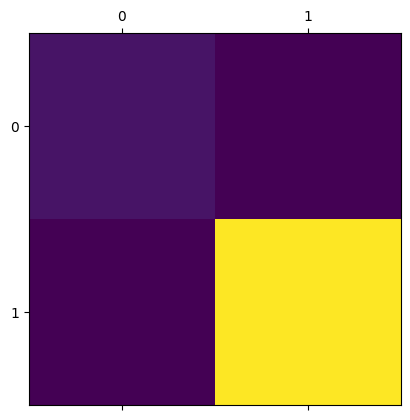

In [10]:
# plot the confusion matrix
import numpy as np
import pylab

cm = np.array([[confusion.tp.cpu(), confusion.fp.cpu()], [confusion.fn.cpu(), confusion.tn.cpu()]])
# cm = cm / cm.sum()
pylab.matshow(cm)

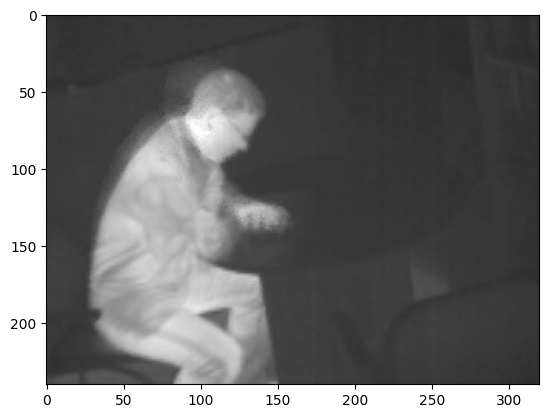

In [11]:
images = sorted([i for i in os.listdir("/mnt/fastdata/CDNet/short/") if i.startswith("thermal_library")])
pylab.imshow(pylab.imread("/mnt/fastdata/CDNet/short/"+images[2000]))